In [ ]:
from dotenv import load_dotenv
from langchain_core.messages import HumanMessage,AIMessage,BaseMessage,SystemMessage,ToolMessage
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool
import os
from lean_interact import LeanREPLConfig, AutoLeanServer, Command,LocalProject
from lean_interact.interface import CommandResponse
import nest_asyncio
from git import Repo
from typing import Optional, TypedDict
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import Annotated,Sequence,TypedDict,List
from utils import *
from typing import TypedDict, Union
import uuid


nest_asyncio.apply()
load_dotenv()

[23:17:16] INFO     For optimal use on Windows, enable long paths by running this command as            ]8;id=167108;file://d:\git_clone\LEL\.pixi\envs\default\Lib\site-packages\lean_interact\utils.py\utils.py]8;;\:]8;id=432229;file://d:\git_clone\LEL\.pixi\envs\default\Lib\site-packages\lean_interact\utils.py#93\93]8;;\
                    administrator:                                                                                 

           INFO     New-ItemProperty -Path "HKLM:\SYSTEM\CurrentControlSet\Control\FileSystem" -Name    ]8;id=813778;file://d:\git_clone\LEL\.pixi\envs\default\Lib\site-packages\lean_interact\utils.py\utils.py]8;;\:]8;id=189152;file://d:\git_clone\LEL\.pixi\envs\default\Lib\site-packages\lean_interact\utils.py#94\94]8;;\
                    LongPathsEnabled -Value 1 -PropertyType DWord -Force                                           

           INFO     For optimal use on Windows, configure git for long paths by running:               ]8;id=536805;file://d:\git_clone\LEL\.pixi\envs\default\Lib\site-packages\lean_interact\utils.py\utils.py]8;;\:]8;id=735213;file://d:\git_clone\LEL\.pixi\envs\default\Lib\site-packages\lean_interact\utils.py#112\112]8;;\

           INFO     git config --global core.longpaths true                                            ]8;id=673247;file://d:\git_clone\LEL\.pixi\envs\default\Lib\site-packages\lean_interact\utils.py\utils.py]8;;\:]8;id=656045;file://d:\git_clone\LEL\.pixi\envs\default\Lib\site-packages\lean_interact\utils.py#113\113]8;;\

API Client initialized.


True

In [2]:
vec_store=VectorStore(r".\src\src_md",r".\src\src_VectorStore")
retriever_tool=vec_store.retriever_tool
#vec_store.sync_md(r".\src\src_pdf")

local_repo_path = "./mathlib4"
if not os.path.exists(local_repo_path):
    print(f"本地路径 {local_repo_path} 不存在，开始克隆 GitHub 仓库...")
    try:
        # 使用 ! 执行系统命令克隆仓库
        github_repo_url="https://github.com/leanprover-community/mathlib4.git"
        Repo.clone_from(github_repo_url, local_repo_path)
        print(f"GitHub 仓库 {github_repo_url} 已成功克隆到 {local_repo_path}")
    except Exception as e:
        print(f"克隆仓库时出错: {e}")
else:
    print(f"本地路径 {local_repo_path} 已存在，跳过克隆操作。")

sync_store 完成
本地路径 ./mathlib4 已存在，跳过克隆操作。


In [ ]:
llm=ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0,
    max_tokens=None,
    timeout=None,
)
prover=Prover(model_ls=["AI-MO/Kimina-Prover-Preview-Distill-7B" for i in range(2)])

try:
    llm.invoke("HI")
    print("model has conneted！\n")
except Exception as e:
    assert Exception("please check your model connect!:{e}")

config = LeanREPLConfig(project=LocalProject(local_repo_path))
server = AutoLeanServer(config)
server.run(Command(cmd="theorem ex (n : Nat) : n = 5 → n = 5 := id"))

model has conneted！



CommandResponse(env=0)

In [4]:
class AgentState(TypedDict):
    initMessages: Annotated[Sequence[BaseMessage], add_messages]
    proverMessages : dict[str,BaseMessage]
    agentMessages : Annotated[Sequence[BaseMessage], add_messages]
    
class LeanState(TypedDict):
    query : str | None 
    background : str | None 
    leanQuery : str | None
    leanTheorem : str | None

class Tree(TypedDict):
    leaves : dict[str , list[Union[str,CommandResponse]]]

In [8]:
print(llm.invoke("HI"))
print(await prover.ainvoke("HI"))

content='Hello! How can I assist you today? 😊' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 1, 'total_tokens': 11, 'completion_tokens_details': None, 'prompt_tokens_details': None, 'thoughts_token_count': 0}, 'model_name': 'gpt-4o', 'system_fingerprint': None, 'id': 'chatcmpl-Mex1V6EPTYVRD21q1QR80VcdFRIQ3q6g', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None} id='run--d8a56588-2611-45be-a620-c73f5116ba6a-0' usage_metadata={'input_tokens': 1, 'output_tokens': 10, 'total_tokens': 11, 'input_token_details': {}, 'output_token_details': {}}


ClientOSError: [Errno 1] [SSL] record layer failure (_ssl.c:2590)

In [ ]:
leanState:LeanState={}
tree:Tree={}

@tool
def updateLeanState(stateName,text:str):
    """
    更新AgentState
    Args:
        stateName:leanState 其中元素的名称
        text:需要写入的内容
    """
    global leanState
    leanState[stateName]=text
    return f"leanState更新完成，更新了{stateName}"

@tool
def update_leaf_message(lean:str):
    """
    向树形结构添加新的解释信息
    
    参数:
        lean: 待解释的文本内容
    
    返回:
        包含操作结果的状态信息
    功能:
        1. 生成唯一标识符作为新节点ID
        2. 创建包含原始文本和解释结果的元组
        3. 将元组添加到树结构的leaves字典中
        4. 返回更新后的树结构信息
    
    依赖:
        - server.run(): 执行命令并返回lean解释器结果
        - uuid.uuid4(): 生成随机唯一标识符的函数
        - tree: 全局变量，存储树形结构的字典
    """
    global tree
    random_id=str(uuid.uudi4())
    tree['leaves'][random_id]=[lean,server.run(Command(cmd=lean))]
    return f"leanMessages 已更新了节点 {random_id}"

@tool
def delete_leaf_message(leaf_id: str) -> dict:
    """
    从树结构中删除指定ID的叶子节点
    
    Args:
        leaf_id: 要删除的叶子节点ID
        
    Returns:
        包含操作结果的字典
    """
    global tree
    if leaf_id not in tree["leaves"]:
        return  f"error : 叶子节点ID '{leaf_id}'不存在"
        
    tree["leaves"].pop(leaf_id)
    return f"叶子节点ID '{leaf_id}'已成功删除"

@tool
def save(filename: str, lean: str) -> str:
    """将lean证明保存为Lean格式的文本文件并结束流程。
    
    参数:
        filename: 文本文件名称。
        lean: 要保存的Lean代码内容。
    """

    # 确保文件名以.lean扩展名结尾
    if not filename.endswith('.lean'):
        filename = f"{filename}.lean"

    try:
        with open(filename, 'w', encoding='utf-8') as file:
            file.write(lean)
        print(f"文档已保存至: {filename}")
        return f"文档已成功保存至 '{filename}'。"
    
    except Exception as e:
        return f"保存文档时出错: {str(e)}"

In [ ]:
systemPrompt={
    "init":"""
    你的任务：
        1.你需要将leanState.query中的内容转换为lean语言，记录在leanState.leanQuery中,或者将leanState.leanQuery中的内容转换为自然语言，记录在leanState.qurey中，在这里，你并不需要解答问题，只需翻译即可。
        2.你需要搜一些背景知识，为了帮助在你之后的模型理解，你需要将你搜集到的知识存储到leanState.background中。
        3.你需要搜索一些关于该题目中使用的lean theorem，你需要将你搜到的知识存储到leanState.leanTheorem中。
    你可以调用的工具：
        1.updateLeanState 用来更新leanState
        2.search_lean_theorem 用来搜索lean theorem的内容
        3.ddgs_search 用来搜索网络中的内容
        4.retriever_tool 用来搜索知识库中的信息
    leanState的结构：
        class LeanState(TypedDict):
            query : str | None 
            background : str | None 
            leanQuery : str | None
            leanTheorem : str | None
    """,
    "prover":f"""
    你的任务：
        1.你需要根据leanState信息的协助下写出证明
            其中 query是问题的自然语言表达
                 backgroud是关于问题的一些背景知识
                 leanQuery是问题的lean语言陈述
                 leanTheorem是问题可能使用到的定理
        2.你可能会参考到以前给出的证明（不一定正确）
            结构即{{"leaves": {{"leaf_id":["lean_proof","leanInterpreted"]}}}}
    """,
    "agent":f"""
    你的任务：
        1.总结proverMessages中的信息，记录在tree中，并且随时更新或删除tree中的内容（使用工具delete_leaf_message或update_leaf_message），你需要保证，百分之五十的证明淘汰率。
        2.当你觉得tree中的证明令你满意，你可以使用工具save来保存该证明（证明包括：lean证明和注释的自然语言证明），这样可以退出程序，完成证明。
        3.当你发现了某个证明引用了不存在的定理，你可以使用search_lean_theorem，你需要将你搜到的知识存储到leanState.leanTheorem中。
    你可以调用的工具：
        1.search_lean_theorem：搜索lean定理
        2.delete_leaf_message：删除tree中某个证明
        3.update_leaf_message：更新证明
        4.updateLeanState：更新leanState
        5.save：保存lean的证明
    tree的结构:
        class Tree(TypedDict):
            leaves : dict[str , list[Union[str,CommandResponse]]]
            结构即 {{"leaves": {{"leaf_id":["lean_proof","leanInterpreted"]}}}}
    leanState的结构：
        class LeanState(TypedDict):
            query : str | None 
            background : str | None 
            leanQuery : str | None
            leanTheorem : str | None
    """
}

init_tools=[updateLeanState,search_lean_theorem,ddgs_search,retriever_tool]
agent_tools=[search_lean_theorem,updateLeanState,save,delete_leaf_message,update_leaf_message]
init_llm=llm.bind_tools(init_tools)
agent_llm=llm.bind_tools(agent_tools)
def call_init_llm(state:AgentState)-> AgentState:
    system=SystemMessage(content=systemPrompt["init"])
    reponse=init_llm.invoke([system]+state["initMessages"])
    return {"initMessages":[reponse]}

async def call_prover_llm(state:AgentState) -> AgentState:
    prompt=f"tree :{tree},leanState:{leanState}"
    system=systemPrompt["prover"]+prompt
    state["proverMessages"]=await  prover.ainvoke(system)
    return state

def cal_agent_llm(state:AgentState)->AgentState:
    if "agentMessages" in state:
        historymess = state["agentMessages"]
    else:
        historymess=[]
    provermess=state["proverMessages"]
    prompt=f"tree:{tree},leanState:{leanState},proverMessages:{provermess}"
    system=SystemMessage(content=systemPrompt["agent"]+prompt)
    reponse=agent_llm.invoke([system]+historymess)
    return {"agentMessages":[reponse]}

def should_init_continue(state :AgentState):
    """check the last massage contants tool call"""
    result=state["initMessages"][-1]
    return hasattr(result,"tool_calls") and len(result.tool_calls) > 0

def should_agent_continue(state: AgentState) -> str:
    """Determine if we should continue or end the conversation."""

    messages = state["agentMessages"]
    
    if not messages:
        return "continue"
    
    # This looks for the most recent tool message....
    for message in reversed(messages):
        if (isinstance(message, ToolMessage) and 
            "文档已成功保存" in message.content):
            return "end" 
        
    return "continue"

def should_agent_prover(state:AgentState):
    result=state["agentMessages"][-1]
    return hasattr(result,"tool_calls") and len(result.tool_calls) > 0

In [ ]:
graph=StateGraph(AgentState)

init_tool_node=ToolNode(init_tools,messages_key="initMessages")
agent_tool_node=ToolNode(agent_tools,messages_key="agentMessages")

graph.add_node("init_node",call_init_llm)
graph.add_node("init_tool_node",init_tool_node)
graph.add_node("prover_node",call_prover_llm)
graph.add_node("agent_node",cal_agent_llm)
graph.add_node("agent_tool_node",agent_tool_node)

graph.add_edge(START,"init_node")
graph.add_edge("init_tool_node","init_node")
graph.add_edge("prover_node","agent_node")

graph.add_conditional_edges("init_node",should_init_continue,{True:"init_tool_node",False:"prover_node"})
graph.add_conditional_edges("agent_tool_node",should_agent_continue,{"continue":"agent_node","end":END})
graph.add_conditional_edges("agent_node",should_agent_prover,{True:"agent_tool_node",False:"prover_node"})
agent=graph.compile()

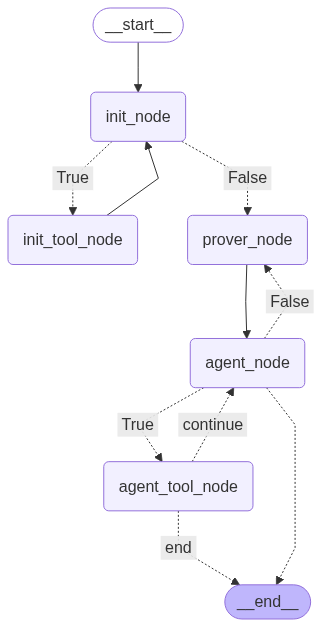

In [ ]:
from IPython.display import display, Image

display(Image(agent.get_graph().draw_mermaid_png()))

In [ ]:
await agent.ainvoke({"initMessages":[HumanMessage(content="为什么根号二不是有理数？")]})

NameError: name 'agent' is not defined

In [ ]:
leanState

{'query': '为什么根号二不是有理数？',
 'leanQuery': '证明 sqrt(2) 是无理数。 (Prove sqrt(2) is irrational.)',
 'background': '根号二不是有理数是一个经典的数学证明，通常使用反证法。证明思路是假设根号二是a/b形式的有理数（其中a和b是互质的整数），然后通过推导得出矛盾，从而证明根号二不是有理数。',
 'leanTheorem': '在Lean中，`irrational_sqrt_two` 定理直接声明了 `Irrational (√2)`，即根号2是无理数。这个定理位于 `Mathlib/Data/Real/Irrational.lean` 文件中。此外，`Irrational` 的定义是 `x ∉ Set.range ((↑) : ℚ → ℝ)`，表示一个实数是无理数，如果它不在有理数到实数的规范嵌入的范围内。还有一些相关的定理，如 `irrational_sqrt_of_multiplicity_odd` 和 `irrational_sqrt_ofNat_iff`，它们提供了更一般的判断平方根是否为无理数的方法。'}

In [ ]:
tree

{}